# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [29]:
# Change here using YOUR first and last names
fn1 = "hospice"
ln1 = "dossou-yovo"
fn2 = "olivier"
ln2 = "aguillon"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_dossou-yovo_hospice_and_aguillon_olivier.ipynb


In [30]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [31]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

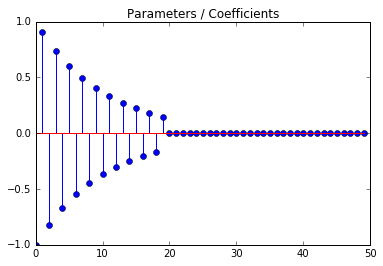

In [32]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [33]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

**Question**:

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

**Response**:

- Function $g(x)$ for lasso penalization :                     $g(x) = s \|x\|_1$
- The proximal operator for lasso penalization:  
$\text{prox}_g(x) = sign(x)(|x| - s.t )+$

- Function $g(x)$ for ridge penalization :                     $g(x) = \frac{s}{2} \|x\|_2^2$
- The proximal operator for ridge penalization:
 $\text{prox}_g(x) = \frac{x}{1 + s.t} $

In [34]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""
    return np.multiply(np.sign(x), np.maximum(np.absolute(x) - s*t, 0))
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s*np.linalg.norm(x, 1)

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    return x / (1 + s*t) 
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return s / 2 * np.linalg.norm(x, 2) ** 2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

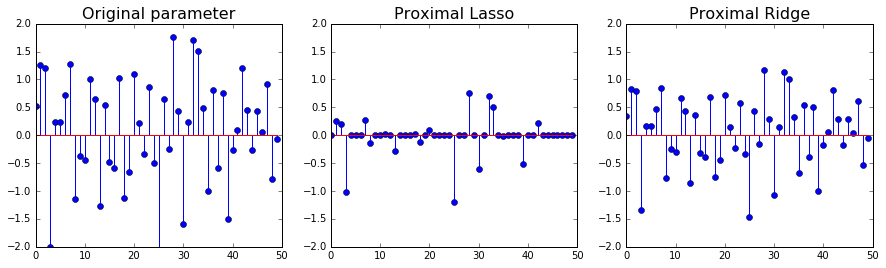

In [35]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

**Question**:

- Comment what you observe (1 or 2 sentences).

**Response**:

Both functions induce sparcity. While the Proximal Ridge reduces all its values by the same factor, the Proximal Lasso assigns some nulls.


## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

**Réponses**:
- The gradient of the linear regression is:
$\nabla f(x)=\frac{1}{n} \ A^t.(A.x- b )$

- The gradient of the logistic regression is:
$\nabla f(x)=-\frac{1}{n} \sum_{i=1}^n (-b_i a_i^t).\exp(-b_i a_i^t x).\frac{1}{1+exp(-b_i a_i^t x)}$

In [36]:
def loss_linreg(x):
    """Least-squares loss"""
    return np.linalg.norm(b-A.dot(x),2)**2/(2*n_samples)

def grad_linreg(x):
    """Leas-squares gradient"""
    return A.T.dot(A.dot(x)-b)/n_samples

def loss_logreg(x):
    """Logistic loss"""
    return np.log(1+np.exp(-np.multiply(b,A.dot(x)))).sum()/n_samples

def grad_logreg(x):
    """Logistic gradient"""
    z=-b*A.dot(x)
    f=np.exp(z)
    log_grad= b*A.T*f/(1+f)
    return -np.sum(log_grad, axis=-1)/n_samples

In [37]:
from scipy.optimize import check_grad

# Checking numerically the gradient of lasso regression

A,_ = simu_linreg(coefs)
_,b = simu_linreg(coefs)
print("Numerical verification of the gradient of linear regression :", check_grad(loss_linreg, grad_linreg, randn(50)))
if check_grad(loss_linreg, grad_linreg, randn(50))<0.01:
    print("             the gradient of linear regression matches")
else:
    print("             the gradient of linear regression doesn't match")

    
# Checking numerically the gradient of logistic regression

A,_ = simu_logreg(coefs)
_,b = simu_logreg(coefs)
print(" ")
print("Numerical verification of the gradient of logistic regression :", check_grad(loss_logreg, grad_logreg, randn(50)))
if check_grad(loss_logreg, grad_logreg, randn(50))< 0.0001:
    print("             the gradient of logistic regression matches")
else:
    print("             the gradient of logistic regression doesn't match")

Numerical verification of the gradient of linear regression : 1.46294806402e-06
             the gradient of linear regression matches
 
Numerical verification of the gradient of logistic regression : 1.2200524664e-07
             the gradient of logistic regression matches


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [38]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(A.T.dot(A), 2) / n_samples
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return lip_linreg(A) / 4
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    from scipy.optimize import check_grad
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print ("Lauching ISTA solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - step*grad_f(x))
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [39]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print ("Lauching FISTA solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        x_new = prox_g(z - step*grad_f(z))
        t_new = (1 + np.sqrt(1+4*t**2)) / 2
        z_new = x_new + (t-1) / t_new * (x_new - x)
        x = x_new
        z = z_new 
        t = t_new

        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [40]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [41]:
# Linear regression with ridge penalization 
A, b = simu_linreg(coefs, n_samples=50, corr=0.5)
L = lip_linreg(A)

x1, obj1, err1 = ista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)

x2, obj2, err2 = fista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.16e-02 | 9.47e-01
      10 | 2.49e-02 | 8.38e-01
      20 | 2.34e-02 | 8.07e-01
      30 | 2.30e-02 | 7.90e-01
      40 | 2.29e-02 | 7.80e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.16e-02 | 9.47e-01
      10 | 2.31e-02 | 8.00e-01
      20 | 2.29e-02 | 7.56e-01
      30 | 2.29e-02 | 7.65e-01
      40 | 2.29e-02 | 7.66e-01


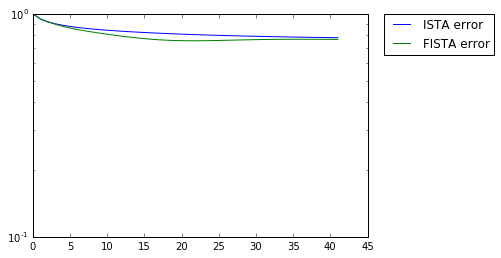

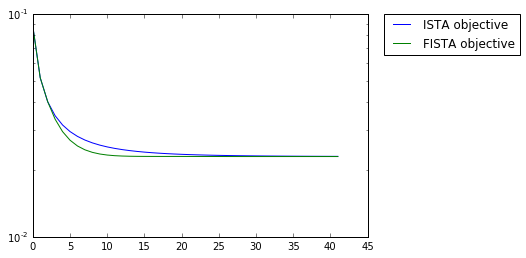

In [42]:
fig, ax = plt.subplots()
ax.semilogy(np.arange(len(err1)), err1, label="ISTA error")
ax.semilogy(np.arange(len(err2)), err2, label="FISTA error")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(obj1)), obj1, label="ISTA objective")
ax.semilogy(np.arange(len(obj2)), obj2, label="FISTA objective")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observations: **
- Both ISTA and FISTA error converge to the same limit on the number of iterations is growing. FISTA error decreases faster than ISTA error.
- Same remark for thre ISTA and FISTA objective


**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

**Responses**

- Study the influence of the correlation of the features on the performance of the optimization algorithms: 
it consists to trace for all differnt type of algorithms based on the correlation

- Study the influence of the correlation of the features on the performance of the optimization algorithms:
trace the rank of the iteration at which the error falls below a threshold, based on the correlation 

ISTA with corr=0.0
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 4.67e-02 | 8.93e-01
      10 | 2.41e-02 | 7.37e-01
      20 | 2.30e-02 | 7.21e-01
      30 | 2.29e-02 | 7.18e-01
      40 | 2.28e-02 | 7.18e-01
ISTA with corr=0.2
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.78e-02 | 8.52e-01
      10 | 2.74e-02 | 6.96e-01
      20 | 2.67e-02 | 6.69e-01
      30 | 2.66e-02 | 6.58e-01
      40 | 2.66e-02 | 6.53e-01
ISTA with corr=0.4
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 4.30e-02 | 9.52e-01
      10 | 2.10e-02 | 8.19e-01
      20 | 1.93e-02 | 8.02e-01
      30 | 1.91e-02 | 7.99e-01
      40 | 1.90e-02 | 7.99e-01
ISTA with corr=0.6
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 4.80e-02 | 9.56e-01
      10 | 2.18e-02 | 8.02e-01
      20 | 1.96e-02 | 7.67e-01
      30 | 1.92e-02 | 7.55e-01
      40 | 1.91e-02 | 7.50e-01
ISTA with corr=0.8
Lauching ISTA solver...
   it    |   obj    |   err   
       0 |

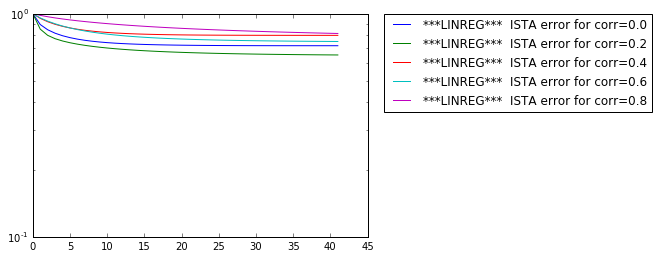

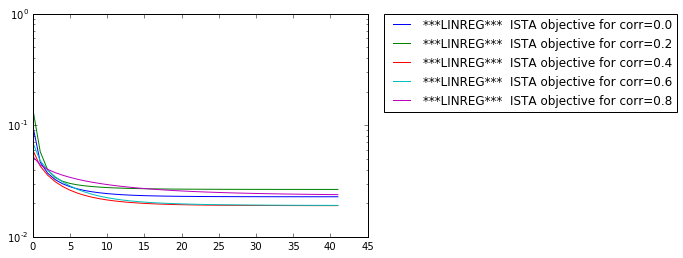

In [43]:
#Question 1 : Influence of the correlation of features on the performance of the optimization algorithms
# Linear regression
  # ISTA


k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])

for i in range(k):
    A, b = simu_linreg(coefs, n_samples=50, corr=i/k)
    L = lip_linreg(A)
    print("ISTA with corr=%s" %(i/k))
       
    x,obj,err=ista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)    
    x_n=np.append(x_n,x)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)
  
err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj))


fig, ax = plt.subplots()    
for i in range(k):    
    corr=i/k
    ax.semilogy(np.arange(len(err)), err_n[i], label="***LINREG***  ISTA error for corr=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for i in range(k):    
    corr=i/k
    ax.semilogy(np.arange(len(obj)), obj_n[i], label="***LINREG***  ISTA objective for corr=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** The correlation of features inluence on the performance of ISTA's linear regression. 

When the correlation of features grows, the distance to the minimum calculated by ISTA algorithm increases.

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.94e-02 | 7.51e-01
      10 | 2.40e-02 | 5.56e-01
      20 | 2.40e-02 | 5.49e-01
      30 | 2.40e-02 | 5.51e-01
      40 | 2.40e-02 | 5.50e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 4.78e-02 | 8.43e-01
      10 | 2.06e-02 | 6.09e-01
      20 | 2.06e-02 | 6.15e-01
      30 | 2.06e-02 | 6.13e-01
      40 | 2.06e-02 | 6.14e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 4.58e-02 | 9.29e-01
      10 | 2.30e-02 | 6.49e-01
      20 | 2.29e-02 | 6.30e-01
      30 | 2.29e-02 | 6.38e-01
      40 | 2.29e-02 | 6.34e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 4.94e-02 | 9.62e-01
      10 | 2.29e-02 | 7.51e-01
      20 | 2.25e-02 | 6.97e-01
      30 | 2.25e-02 | 7.10e-01
      40 | 2.25e-02 | 7.09e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.66e-02 | 9.89e-01
      10 | 1.43e-02 | 9.39e-01
      20 | 1.34e-02 | 9.06e-01
      3

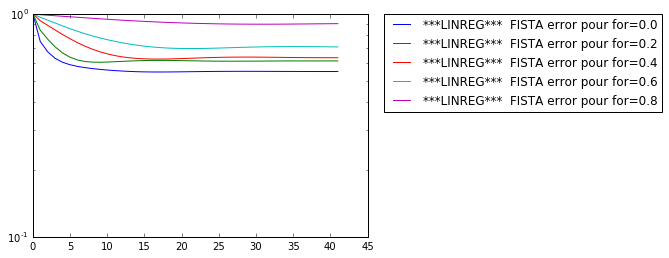

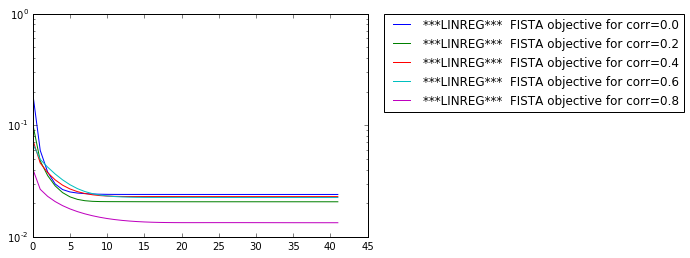

In [44]:
# Question 1 : Influence of the correlation of features on the performance of the optimization algorithms
# Linear regression
  # FISTA
k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])

for i in range(k):
    A, b = simu_linreg(coefs, n_samples=50, corr=i/k)
    L = lip_linreg(A)
    x, obj,err=fista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)
    x_n=np.append(x_n,x)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)

err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj))
    
fig, ax = plt.subplots()    
for i in range(k):    
    corr=i/k
    
    ax.semilogy(np.arange(len(err)), err_n[i], label="***LINREG***  FISTA error pour for=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for i in range(k):    
    corr=i/k
    ax.semilogy(np.arange(len(obj)), obj_n[i], label="***LINREG***  FISTA objective for corr=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** The correlation of features inluence on the performance of FISTA's linear regression. 

When the correlation of features grows, the distance to the minimum calculated by FISTA algorithm increases.

** Conclusion: **  For linear regression, the error calculated with ISTA and FISTA algorithms increases when the correlation of features grows.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.46e-02 | 9.27e-01
      10 | 2.10e-02 | 8.53e-01
      20 | 2.10e-02 | 8.51e-01
      30 | 2.10e-02 | 8.51e-01
      40 | 2.10e-02 | 8.51e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.63e-02 | 9.51e-01
      10 | 2.31e-02 | 9.24e-01
      20 | 2.30e-02 | 9.24e-01
      30 | 2.30e-02 | 9.24e-01
      40 | 2.30e-02 | 9.24e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.62e-02 | 9.63e-01
      10 | 2.23e-02 | 9.48e-01
      20 | 2.23e-02 | 9.48e-01
      30 | 2.23e-02 | 9.48e-01
      40 | 2.23e-02 | 9.48e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.00e-02 | 9.67e-01
      10 | 2.63e-02 | 8.69e-01
      20 | 2.62e-02 | 8.54e-01
      30 | 2.62e-02 | 8.50e-01
      40 | 2.62e-02 | 8.50e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.80e-02 | 9.97e-01
      10 | 2.46e-02 | 1.01e+00
      20 | 2.44e-02 | 1.01e+00
      30 | 2

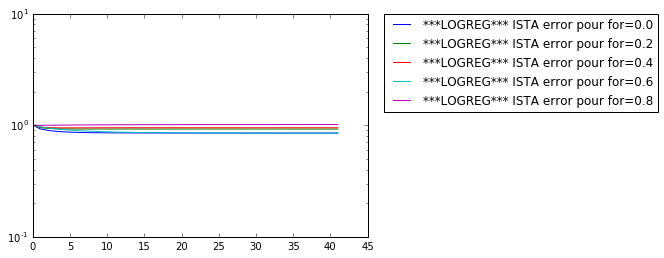

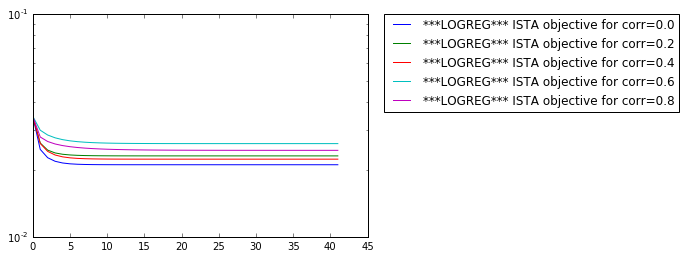

In [45]:
# Question 1 : Influence of the correlation of features on the performance of the optimization algorithms
# Logistic regression
  # ISTA
k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])

for i in range(k):
    A, b = simu_logreg(coefs, n_samples=50, corr=i/k)
    L = lip_logreg(A)
    _, obj, err=ista(x0, loss_logreg, grad_logreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)

err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj))

fig, ax = plt.subplots()    
for i in range(k):    
    corr=i/k
    ax.semilogy(np.arange(len(err)), err_n[i], label="***LOGREG*** ISTA error pour for=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for i in range(k):    
    corr=i/k
    ax.semilogy(np.arange(len(obj)), obj_n[i], label="***LOGREG*** ISTA objective for corr=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


**Observation : ** The correlation of features inluence on the performance of ISTA's logistic regression. 

When the correlation of features grows, the distance to the minimum calculated with ISTA algorithm increases.

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.42e-02 | 8.89e-01
      10 | 2.03e-02 | 7.78e-01
      20 | 2.03e-02 | 7.79e-01
      30 | 2.03e-02 | 7.79e-01
      40 | 2.03e-02 | 7.79e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.65e-02 | 9.17e-01
      10 | 2.21e-02 | 8.35e-01
      20 | 2.21e-02 | 8.36e-01
      30 | 2.21e-02 | 8.36e-01
      40 | 2.21e-02 | 8.36e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.86e-02 | 9.74e-01
      10 | 2.42e-02 | 9.68e-01
      20 | 2.42e-02 | 9.67e-01
      30 | 2.42e-02 | 9.67e-01
      40 | 2.42e-02 | 9.67e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.06e-02 | 9.84e-01
      10 | 2.52e-02 | 9.70e-01
      20 | 2.52e-02 | 9.68e-01
      30 | 2.52e-02 | 9.68e-01
      40 | 2.52e-02 | 9.68e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.17e-02 | 9.96e-01
      10 | 2.63e-02 | 1.02e+00
      20 | 2.63e-02 | 1.03e+00
      3

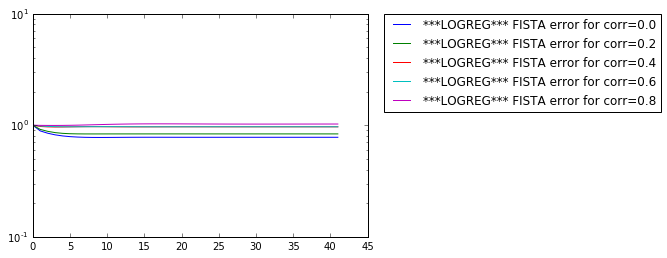

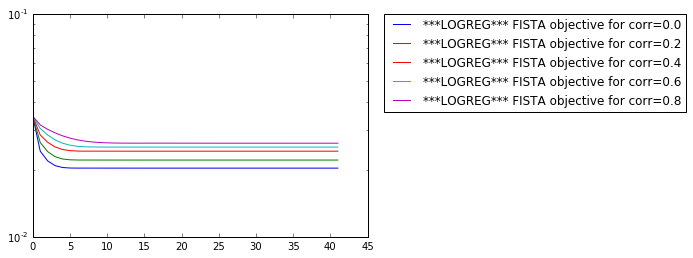

In [46]:
# Question 1 : Influence of the correlation of features on the performance of the optimization algorithms
# Logistic regression
  # FISTA
k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])

for i in range(k):
    A, b = simu_logreg(coefs, n_samples=50, corr=i/k)
    L = lip_logreg(A)
    _, obj, err=fista(x0, loss_logreg, grad_logreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)

err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj))

fig, ax = plt.subplots()    
for i in range(k):    
    corr=i/k
    ax.semilogy(np.arange(len(err)), err_n[i], label="***LOGREG*** FISTA error for corr=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for i in range(k):    
    corr=i/k
    ax.semilogy(np.arange(len(obj)), obj_n[i], label="***LOGREG*** FISTA objective for corr=%s" %corr)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** The correlation of features inluence on the performance of FISTA's logistic regression. 

When the correlation of features grows, the distance to the minimum calculated by FISTA algorithm increases.

** Conclusion: **For logistic regression, the distance to the minimum calculated with ISTA and FISTA algorithms increases when the correlation of features grows. Then, for logistic regression, the correlation of feature must not be large

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.43e-02 | 9.33e-01
      10 | 1.64e-02 | 7.80e-01
      20 | 1.17e-02 | 7.61e-01
      30 | 9.71e-03 | 7.68e-01
      40 | 8.46e-03 | 7.86e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.50e-02 | 9.91e-01
      10 | 5.50e-02 | 9.90e-01
      20 | 5.50e-02 | 9.90e-01
      30 | 5.50e-02 | 9.90e-01
      40 | 5.50e-02 | 9.90e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 7.48e-02 | 9.92e-01
      10 | 7.48e-02 | 9.91e-01
      20 | 7.48e-02 | 9.91e-01
      30 | 7.48e-02 | 9.91e-01
      40 | 7.48e-02 | 9.91e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 7.54e-02 | 9.94e-01
      10 | 7.54e-02 | 9.94e-01
      20 | 7.54e-02 | 9.94e-01
      30 | 7.54e-02 | 9.94e-01
      40 | 7.54e-02 | 9.94e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 8.82e-02 | 9.95e-01
      10 | 8.82e-02 | 9.95e-01
      20 | 8.82e-02 | 9.95e-01
      30 | 8

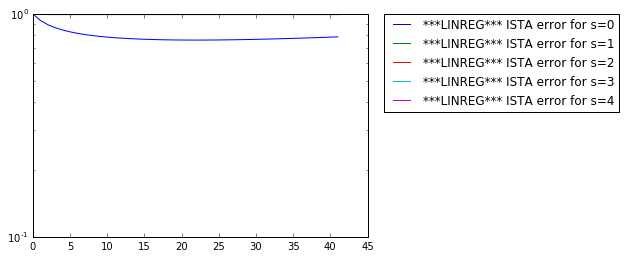

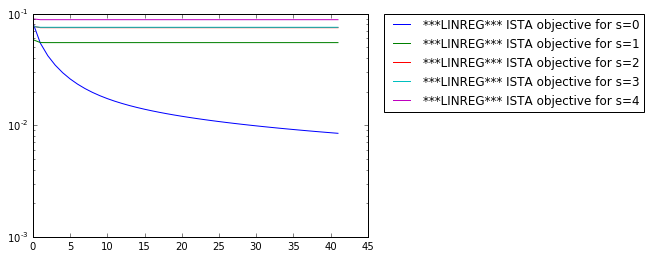

In [47]:
# Question 2: Influence of level of ridge penalisation on the performance of the optimization algorithms
# Linear regression
  # Pour le ISTA
k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])

for s in range(k):
    A, b = simu_linreg(coefs, n_samples=50, corr=0.5)
    L = lip_linreg(A)
    _, obj, err=ista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)

err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj)) 

fig, ax = plt.subplots()    
for s in range(k):    
    ax.semilogy(np.arange(len(err)), err_n[s], label="***LINREG*** ISTA error for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for s in range(k):    
    ax.semilogy(np.arange(len(obj)), obj_n [s], label="***LINREG*** ISTA objective for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** The level of ridge penalisation inluence on the performance of ISTA's linear regression. 

When the level of ridge penalisation increases, the distance to the minimum calculated by ISTA algoritm increases too.

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 4.30e-02 | 9.41e-01
      10 | 4.60e-03 | 7.26e-01
      20 | 2.22e-03 | 7.48e-01
      30 | 1.62e-03 | 7.92e-01
      40 | 1.27e-03 | 8.30e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 9.23e-02 | 9.82e-01
      10 | 9.22e-02 | 9.78e-01
      20 | 9.22e-02 | 9.78e-01
      30 | 9.22e-02 | 9.78e-01
      40 | 9.22e-02 | 9.78e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.16e-02 | 9.94e-01
      10 | 5.16e-02 | 9.94e-01
      20 | 5.16e-02 | 9.94e-01
      30 | 5.16e-02 | 9.94e-01
      40 | 5.16e-02 | 9.94e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 6.76e-02 | 9.95e-01
      10 | 6.76e-02 | 9.95e-01
      20 | 6.76e-02 | 9.95e-01
      30 | 6.76e-02 | 9.95e-01
      40 | 6.76e-02 | 9.95e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 9.36e-02 | 9.95e-01
      10 | 9.36e-02 | 9.95e-01
      20 | 9.36e-02 | 9.95e-01
      3

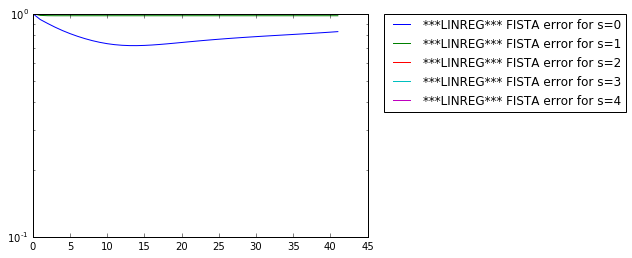

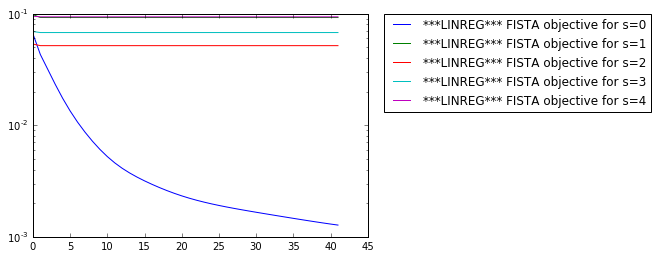

In [48]:
# Question 2: Influence of level of ridge penalisation on the performance of the optimization algorithms
# Linear regression
  # Pour le FISTA
k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])
                  
for s in range(k):
    A, b = simu_linreg(coefs, n_samples=50, corr=0.5)
    L = lip_linreg(A)
    _, obj, err=fista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)

err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj)) 
                  
fig, ax = plt.subplots()    
for s in range(k):    
    ax.semilogy(np.arange(len(err)), err_n[s], label="***LINREG*** FISTA error for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for s in range(k):    
    ax.semilogy(np.arange(len(obj)), obj_n[s], label="***LINREG*** FISTA objective for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** The level of ridge penalisation inluence on the performance of FISTA's linear regression.  

When the level of ridge penalisation increases, the distance to the minimum calculated by FISTA algoritm increases too.  

** Conclusion: ** For the linear regression, when the level of ridge penalization increases, the distance to the minimum increases. 

It is not a good idea to take a large level of ridge penalization.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.36e-02 | 9.66e-01
      10 | 1.15e-02 | 9.12e-01
      20 | 8.12e-03 | 9.62e-01
      30 | 6.26e-03 | 1.05e+00
      40 | 5.06e-03 | 1.14e+00
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.44e-02 | 9.97e-01
      10 | 3.44e-02 | 9.97e-01
      20 | 3.44e-02 | 9.97e-01
      30 | 3.44e-02 | 9.97e-01
      40 | 3.44e-02 | 9.97e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.44e-02 | 9.98e-01
      10 | 3.44e-02 | 9.98e-01
      20 | 3.44e-02 | 9.98e-01
      30 | 3.44e-02 | 9.98e-01
      40 | 3.44e-02 | 9.98e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.46e-02 | 9.99e-01
      10 | 3.46e-02 | 9.99e-01
      20 | 3.46e-02 | 9.99e-01
      30 | 3.46e-02 | 9.99e-01
      40 | 3.46e-02 | 9.99e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.46e-02 | 9.99e-01
      10 | 3.46e-02 | 9.99e-01
      20 | 3.46e-02 | 9.99e-01
      30 | 3

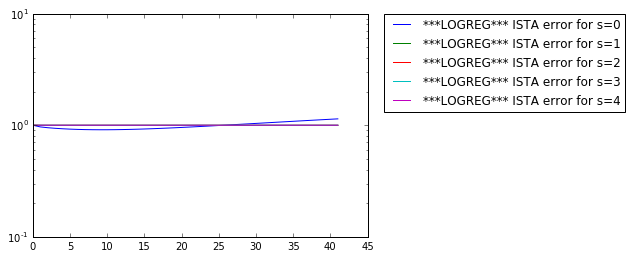

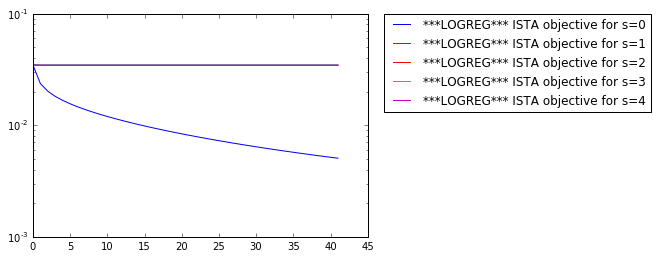

In [49]:
# Question 2: Influence of level of ridge penalisation on the performance of the optimization algorithms
# Logistic regression
  # Pour le ISTA
k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])

for s in range(k):
    A, b = simu_logreg(coefs, n_samples=50, corr=0.5)
    L = lip_logreg(A)
    _, obj, err=ista(x0, loss_logreg, grad_logreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)

err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj)) 

fig, ax = plt.subplots()    
for s in range(k):    
    ax.semilogy(np.arange(len(err)), err_n[s], label="***LOGREG*** ISTA error for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for s in range(k):    
    ax.semilogy(np.arange(len(obj)), obj_n[s], label="***LOGREG*** ISTA objective for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** The level of ridge penalisation inluence on the performance of ISTA's logistic regression.  

When the level of ridge penalisation increases, the distance to the minimum calculated by FISTA algoritm increases too.

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.80e-02 | 9.54e-01
      10 | 1.00e-02 | 1.10e+00
      20 | 3.84e-03 | 1.87e+00
      30 | 1.77e-03 | 2.61e+00
      40 | 9.69e-04 | 3.21e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.43e-02 | 9.97e-01
      10 | 3.43e-02 | 9.97e-01
      20 | 3.43e-02 | 9.97e-01
      30 | 3.43e-02 | 9.97e-01
      40 | 3.43e-02 | 9.97e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.44e-02 | 9.99e-01
      10 | 3.44e-02 | 9.99e-01
      20 | 3.44e-02 | 9.99e-01
      30 | 3.44e-02 | 9.99e-01
      40 | 3.44e-02 | 9.99e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.46e-02 | 9.99e-01
      10 | 3.46e-02 | 9.99e-01
      20 | 3.46e-02 | 9.99e-01
      30 | 3.46e-02 | 9.99e-01
      40 | 3.46e-02 | 9.99e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.46e-02 | 9.99e-01
      10 | 3.46e-02 | 9.99e-01
      20 | 3.46e-02 | 9.99e-01
      3

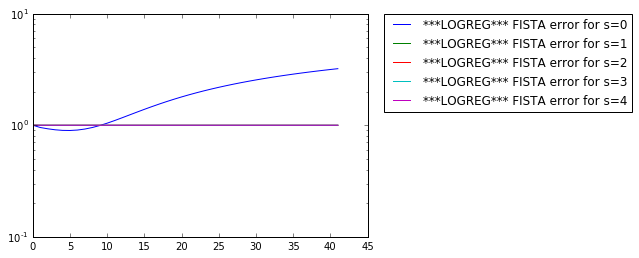

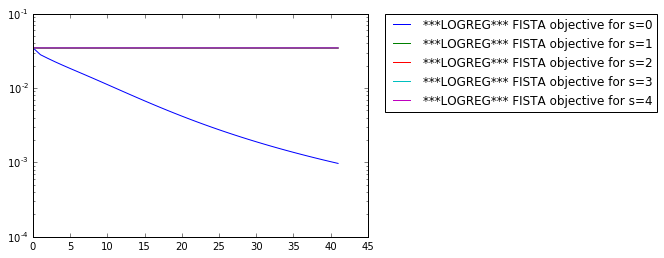

In [50]:
# Question 2: Influence of level of ridge penalisation on the performance of the optimization algorithms
# Logistic regression
  # Pour le FISTA
k=5
x_n = np.array([])
obj_n  = np.array([])
err_n  = np.array([])

for s in range(k):
    A, b = simu_logreg(coefs, n_samples=50, corr=0.5)
    L = lip_logreg(A)
    _, obj, err=fista(x0, loss_logreg, grad_logreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter, x_true=coefs, verbose=True)
    obj_n=np.append(obj_n,obj)
    err_n=np.append(err_n,err)

err_n = err_n.reshape(k,len(err))
obj_n = obj_n.reshape(k,len(obj)) 

fig, ax = plt.subplots()    
for s in range(k):    
    ax.semilogy(np.arange(len(err)), err_n[s], label="***LOGREG*** FISTA error for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig, ax = plt.subplots()
for s in range(k):    
    ax.semilogy(np.arange(len(obj)), obj_n[s], label="***LOGREG*** FISTA objective for s=%s" %s)
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** The level of ridge penalisation also inluence on the performance of FISTA's logistic regression.  

When the level of ridge penalisation increases, the distance to the minimum calculated by FISTA algoritm increases too.

** Conclusion: ** For the linear regression, when the level of ridge penalization increases, the distance to the minimum increases. 

It is not a good idea to take a large level of ridge penalization.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 9.09e-02 | 9.95e-01
      10 | 9.09e-02 | 9.95e-01
      20 | 9.09e-02 | 9.95e-01
      30 | 9.09e-02 | 9.95e-01
      40 | 9.09e-02 | 9.95e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 9.09e-02 | 9.95e-01
      10 | 9.09e-02 | 9.95e-01
      20 | 9.09e-02 | 9.95e-01
      30 | 9.09e-02 | 9.95e-01
      40 | 9.09e-02 | 9.95e-01
42 42


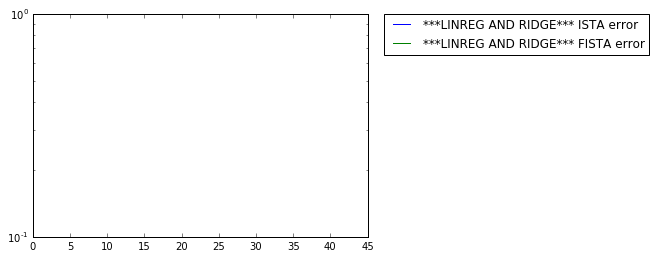

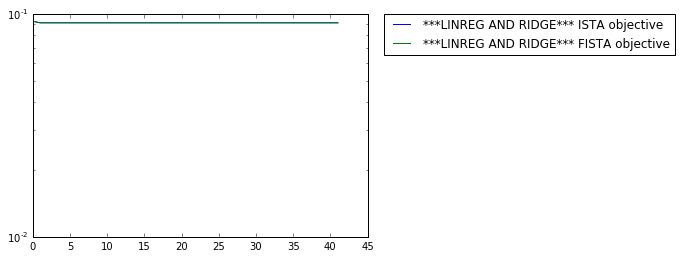

In [57]:
# Question 3: Compare the performance of the optimization algorithms for ridge and lasso
  #Linear regression
     # Ridge
A, b = simu_linreg(coefs, n_samples=50, corr=0.5)
L = lip_linreg(A)

x1, obj1, err1 = ista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)
x2, obj2, err2 = fista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)
      
fig, ax = plt.subplots()
ax.semilogy(np.arange(len(err1)), err1, label="***LINREG AND RIDGE*** ISTA error")
ax.semilogy(np.arange(len(err2)), err2, label="***LINREG AND RIDGE*** FISTA error")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(obj1)), obj1, label="***LINREG AND RIDGE*** ISTA objective")
ax.semilogy(np.arange(len(obj2)), obj2, label="***LINREG AND RIDGE*** FISTA objective")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** Its seems the performance of the optimization algorithms has no effect on ISTA and FISTA from linear with ridge penalization.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 8.47e-02 | 1.00e+00
      10 | 8.47e-02 | 1.00e+00
      20 | 8.47e-02 | 1.00e+00
      30 | 8.47e-02 | 1.00e+00
      40 | 8.47e-02 | 1.00e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 8.47e-02 | 1.00e+00
      10 | 8.47e-02 | 1.00e+00
      20 | 8.47e-02 | 1.00e+00
      30 | 8.47e-02 | 1.00e+00
      40 | 8.47e-02 | 1.00e+00


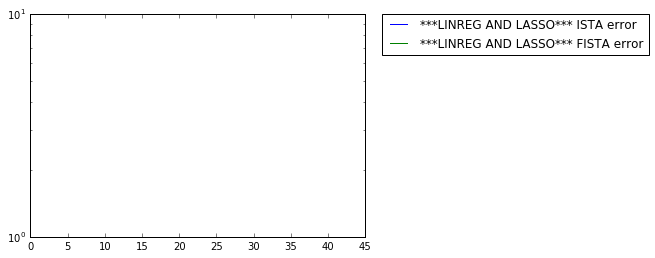

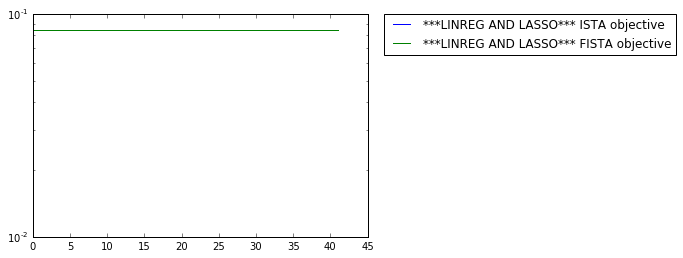

In [59]:
# Question 3: Compare the performance of the optimization algorithms for ridge and lasso
  #Linear regression
     # Lasso
A, b = simu_linreg(coefs, n_samples=50, corr=0.5)
L = lip_linreg(A)
x1, obj1, err1 = ista(x0, loss_linreg, grad_linreg, lasso, lambda x : prox_lasso(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)
x2, obj2, err2 = fista(x0, loss_linreg, grad_linreg, lasso, lambda x : prox_lasso(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(err1)), err1, label="***LINREG AND LASSO*** ISTA error")
ax.semilogy(np.arange(len(err2)), err2, label="***LINREG AND LASSO*** FISTA error")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(obj1)), obj1, label="***LINREG AND LASSO*** ISTA objective")
ax.semilogy(np.arange(len(obj2)), obj2, label="***LINREG AND LASSO*** FISTA objective")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** Its seems the performance of the optimization algorithms has no effect on ISTA and FISTA from linear regression with lasso penalization.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.46e-02 | 9.99e-01
      10 | 3.46e-02 | 9.99e-01
      20 | 3.46e-02 | 9.99e-01
      30 | 3.46e-02 | 9.99e-01
      40 | 3.46e-02 | 9.99e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.46e-02 | 9.99e-01
      10 | 3.46e-02 | 9.99e-01
      20 | 3.46e-02 | 9.99e-01
      30 | 3.46e-02 | 9.99e-01
      40 | 3.46e-02 | 9.99e-01


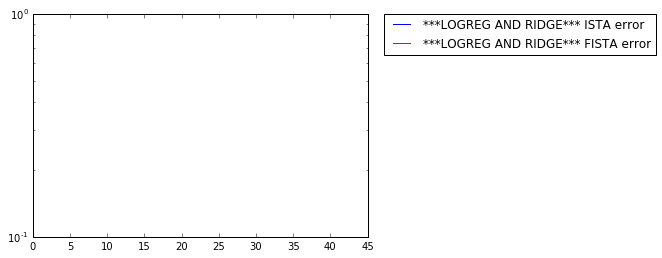

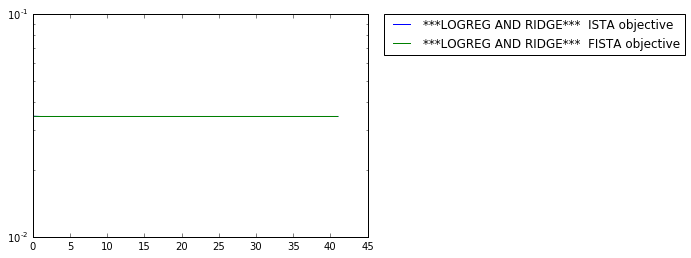

In [27]:
# Question 3: Compare the performance of the optimization algorithms for ridge and lasso
  #Logistic regression
     # Ridge
        
A, b = simu_logreg(coefs, n_samples=50, corr=0.5)
L = lip_logreg(A)

x1, obj1, err1 = ista(x0, loss_logreg, grad_logreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)
x2, obj2, err2 = fista(x0, loss_logreg, grad_logreg, ridge, lambda x : prox_ridge(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(err1)), err1, label="***LOGREG AND RIDGE*** ISTA error")
ax.semilogy(np.arange(len(err2)), err2, label="***LOGREG AND RIDGE*** FISTA error")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(obj1)), obj1, label="***LOGREG AND RIDGE***  ISTA objective")
ax.semilogy(np.arange(len(obj2)), obj2, label="***LOGREG AND RIDGE***  FISTA objective")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** Its seems the performance of the optimization algorithms has no effect on ISTA and FISTA from logistic regression with ridge penalization.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.47e-02 | 1.00e+00
      10 | 3.47e-02 | 1.00e+00
      20 | 3.47e-02 | 1.00e+00
      30 | 3.47e-02 | 1.00e+00
      40 | 3.47e-02 | 1.00e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.47e-02 | 1.00e+00
      10 | 3.47e-02 | 1.00e+00
      20 | 3.47e-02 | 1.00e+00
      30 | 3.47e-02 | 1.00e+00
      40 | 3.47e-02 | 1.00e+00


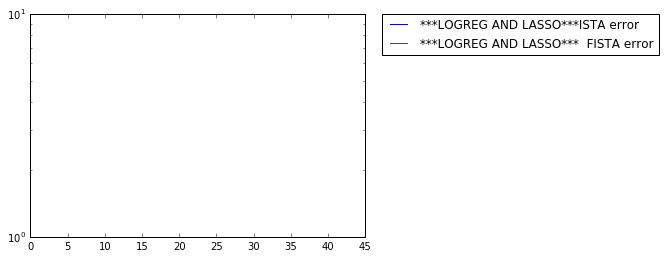

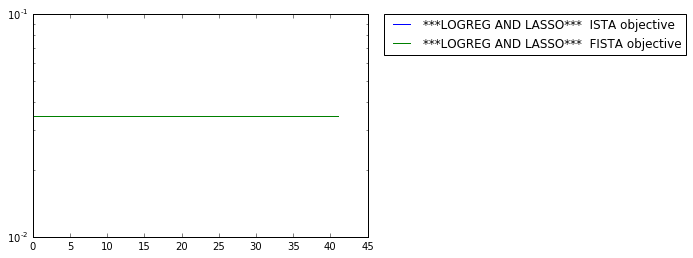

In [26]:
# Question 3: Compare the performance of the optimization algorithms for ridge and lasso
  #Logistic regression
     # Lasso

x1, obj1, err1 = ista(x0, loss_logreg, grad_logreg, lasso, lambda x : prox_lasso(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)
x2, obj2, err2 = fista(x0, loss_logreg, grad_logreg, lasso, lambda x : prox_lasso(x, s, 1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(err1)), err1, label="***LOGREG AND LASSO***ISTA error")
ax.semilogy(np.arange(len(err2)), err2, label="***LOGREG AND LASSO***  FISTA error")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots()
ax.semilogy(np.arange(len(obj1)), obj1, label="***LOGREG AND LASSO***  ISTA objective")
ax.semilogy(np.arange(len(obj2)), obj2, label="***LOGREG AND LASSO***  FISTA objective")
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Observation : ** Its seems the performance of the optimization algorithms with linear regression for lasso has no effect

**Comment : **
- The algorithms converge faster when the features are weakly correlated. 
- With a high level of ridge penalisation, the algorithms give better results. 